In [34]:
from tensorflow.keras.models import load_model
from CardIAc_modules.custom_objects import c_o as custom_objects_imported
from CardIAc_modules.models_utils import remove_extra_inputs_outputs
from CardIAc_modules.AISeg_config import logic_IC, label_tissues, myo_density
import os
from natsort import natsorted
import SimpleITK as sitk
import numpy as np
from skimage import transform
from CardIAc_modules.images_utilities import normalize_image, NpArray2VTK
from skimage import morphology
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.util import montage

path_center = 'models/vnet_rlo_2Dcenter.h5'
path_segment = 'models/GVUNet_cardiac.h5'
patient = 'v9'
data_folder = os.path.join(os.getcwd(),'MHD_Data',patient,'cSAX')

array_images = [
    sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_folder, f)))
    for f in natsorted(os.listdir(data_folder))
    if f.endswith(".mhd") and f.startswith(f"{patient}_cSAX_time")
]

# Load models, labels by default: rv(1), myo(2) lv(3)
model1 = load_model(path_center, custom_objects=custom_objects_imported)
model2 = load_model(path_segment, custom_objects=custom_objects_imported)

# Remove extra inputs and extra outputs if they are found
try:
    model2 = remove_extra_inputs_outputs(model2,logic_IC['cnn_input_label'], logic_IC['cnn_output_label'])
except:
    pass

input_shape_m1 = (64,64)
input_shape_m2 = (128,128)

frames = 30

# Center detection (CNN first model)
frames_shape = (14,256,256) # (z,256,256)
slice_shape = (256,256) # (256,256)
volumes = np.zeros((frames,) + frames_shape) # (frames, z, 256, 256)
volumes = np.array(array_images)

firstFrame = sitk.GetArrayFromImage(images[0]) # (z,256,256)
middleSlice = firstFrame.shape[0]//2
middleSlice = firstFrame[middleSlice] # (256,256)
middleSlice = transform.resize(middleSlice, input_shape_m1, mode='symmetric').astype('float32') # (64,64)
center = normalize_image(middleSlice)
center = model1.predict(center[np.newaxis,:,:,np.newaxis]).squeeze() # (64,64)

# Resize to original shape to compute CM
center = np.round(transform.resize(center, slice_shape, mode='symmetric')).astype(int)

# Compute centroid of heart (instead of scaling) 
# (x,y) --> (y,x) swap for slicer is done later
cm = np.array(ndimage.measurements.center_of_mass(center))
print("\nCM = ( {}, {} )".format(cm[0], cm[1]))

spacing = images[0].GetSpacing()
r = int(round(logic_IC['cnn_roi_size']/spacing[0])) # 90 [mm] // 1.25 [pix/mm] = 72 [pix]
xcm, ycm = cm.round().astype(int)
xleft, xright = xcm - r, xcm + r
ydown, yup = ycm - r, ycm + r

rois = volumes[...,xleft:xright,ydown:yup] # (frames, z, x, y)  
rois.shape = (rois.shape[0]*rois.shape[1],) + rois.shape[2:] # (frames*z, x, y)

model2_input = np.zeros((rois.shape[0],) + input_shape_m2) # (frames*z, 128, 128)

for slice_frame in range(rois.shape[0]):
    I = transform.resize(rois[slice_frame], input_shape_m2, mode='symmetric').astype('float32') # (128,128) 
    model2_input[slice_frame] = normalize_image(I)

# Second Model: Segmentation
seg = model2.predict(model2_input[...,np.newaxis]) # (z, 128,128,n_classes)

# ----------------------------------------------
# Container for segmentated images
imgs_seg = np.zeros((rois.shape[0],) + slice_shape, dtype=int) # (frames*z, 256, 256)

for i in range(seg.shape[0]):    
    # Case of 3 classes

    # This is the order in Net output
    myo_i = seg[i,...,0]
    lv_i = seg[i,...,1]
    rv_i = seg[i,...,2]

    # resize and round (Check this--> Rois shape???? or original shape???)
    rv_i = np.round(transform.resize(rv_i, rois.shape[1:], mode='symmetric')).astype(int)
    myo_i = np.round(transform.resize(myo_i, rois.shape[1:], mode='symmetric')).astype(int)
    lv_i = np.round(transform.resize(lv_i, rois.shape[1:], mode='symmetric')).astype(int)

    # Avoid intersection between rv-myo and lv-myo classes
    rv_myo = rv_i + myo_i
    lv_myo = lv_i + myo_i
    rv_i[rv_myo == 2] = 0
    lv_i[lv_myo == 2] = 0

    # Assign labels (hardcoded TODO: let user select labels) ; 1:RV, 2:myo, 3:LV
    I_seg = label_tissues['RV']*rv_i + label_tissues['myo']*myo_i + label_tissues['LV']*lv_i

    imgs_seg[i,xleft:xright,ydown:yup] = I_seg

imgs_seg.shape = volumes.shape # (frames, z, 256, 256)

# print(np.shape(model2_input))
# plt.figure()
# plt.imshow(model2_input[7])
# plt.figure()
# plt.title("ROI S")
# plt.imshow(montage(rois))
# plt.show()

/var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_20646/1071684281.py:60: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  cm = np.array(ndimage.measurements.center_of_mass(center))



CM = ( 146.88550420168067, 110.99474789915966 )


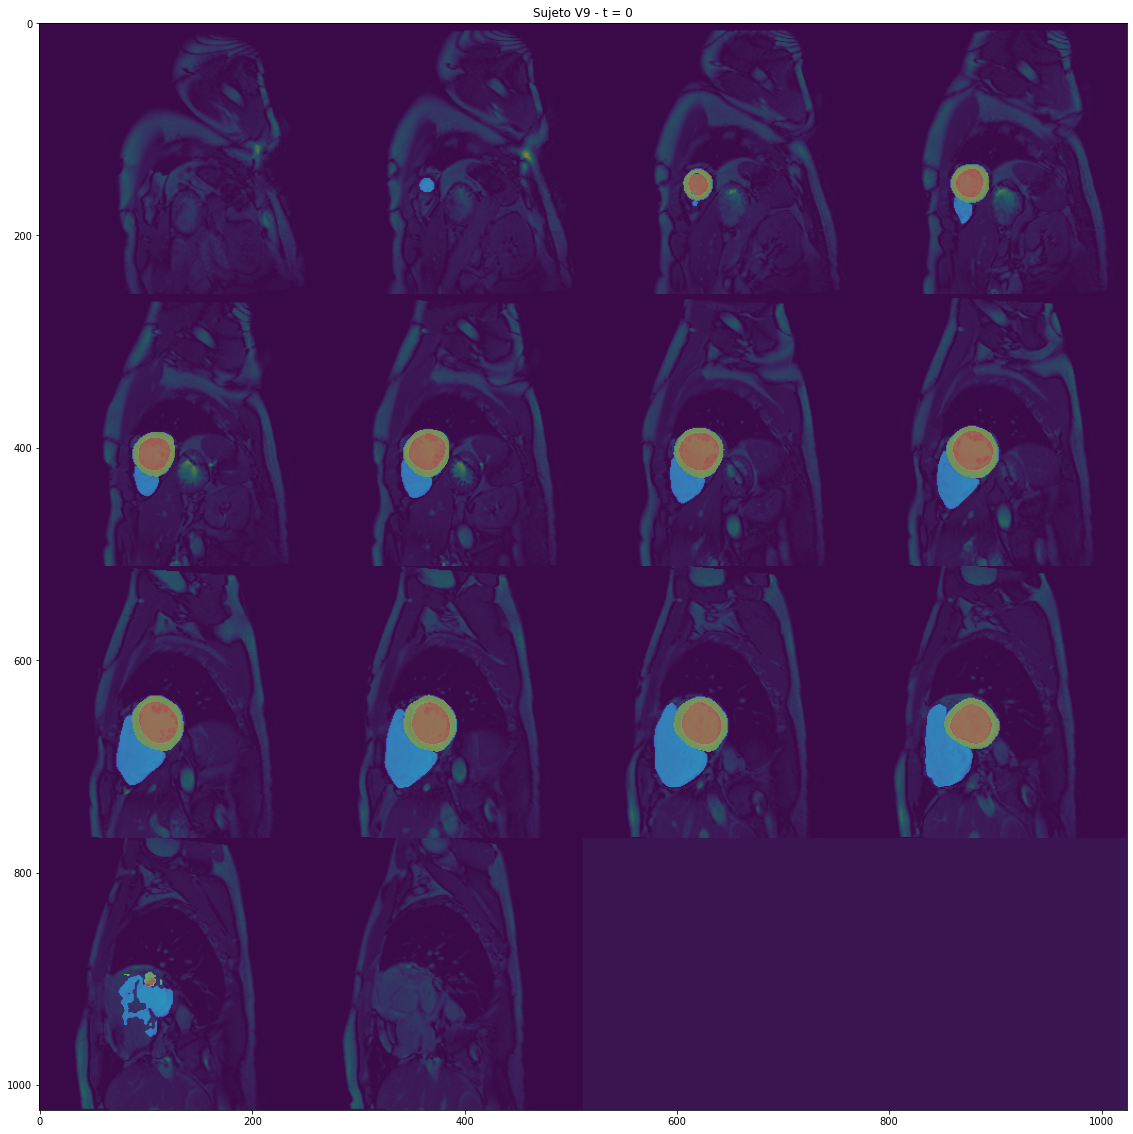

In [33]:
plt.figure(figsize=(20,20))
plt.title("Sujeto V9 - t = 0")
plt.imshow(montage(volumes[0]))
plt.imshow(montage(imgs_seg[0]), alpha=0.5, cmap='turbo')
#plt.colorbar()
plt.show()

In [12]:
imgs_seg.shape

(30, 14, 256, 256)

In [4]:
xleft

75